## Experimenting with full cleaned datasets (larger Data)

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
from pathlib import Path

In [12]:
com = pd.read_csv("../../data/full/comets_clean.csv").assign(label=0)
ast = pd.read_csv("../../data/full/asteroids_clean.csv").assign(label=1)


# balanced subset
ast_bal = ast.sample(n=len(com), random_state=42)
df = pd.concat([ast_bal, com], ignore_index=True)

X = df[["e","q","i"]]  # shared orbital features
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

logreg = make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000, class_weight="balanced"))
logreg.fit(X_train, y_train)
print("LogReg\n", classification_report(y_test, logreg.predict(X_test), target_names=["comet","asteroid"]))

rf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced_subsample")
rf.fit(X_train, y_train)
print("RF\n", classification_report(y_test, rf.predict(X_test), target_names=["comet","asteroid"]))


LogReg
               precision    recall  f1-score   support

       comet       0.98      0.96      0.97       687
    asteroid       0.96      0.98      0.97       687

    accuracy                           0.97      1374
   macro avg       0.97      0.97      0.97      1374
weighted avg       0.97      0.97      0.97      1374

RF
               precision    recall  f1-score   support

       comet       0.99      0.98      0.98       687
    asteroid       0.98      0.99      0.98       687

    accuracy                           0.98      1374
   macro avg       0.98      0.98      0.98      1374
weighted avg       0.98      0.98      0.98      1374



In [13]:
# Define sizes (balanced on the smaller class)
sizes = [1000, 3000, min(2*len(com), 8000)]  # to run after loading "com" and "ast"

# Define dataset sizes
sizes = [1000, 3000, min(2*len(com), 8000)]  # must run after loading "com" and "ast"

def eval_size_rf(n_total, n_splits=100):
    # balanced sample count per class
    n_per = min(n_total // 2, len(com), len(ast))

    # balanced subsets
    com_sub = com.sample(n=n_per, random_state=42)
    ast_sub = ast.sample(n=n_per, random_state=42)

    # combine into one dataframe
    df_sub = pd.concat([com_sub, ast_sub], ignore_index=True)

    # features
    X_sub = df_sub[["e", "q", "i"]].values
    y_sub = df_sub["label"].values

    # repeated splits
    splitter = StratifiedShuffleSplit(
        n_splits=n_splits,
        test_size=0.2,
        random_state=42
    )

    accs = []
    precs = []
    recs = []
    f1s = []

    for train_idx, test_idx in splitter.split(X_sub, y_sub):

        clf = RandomForestClassifier(
            n_estimators=300,
            class_weight="balanced_subsample"
        )

        clf.fit(X_sub[train_idx], y_sub[train_idx])
        y_pred = clf.predict(X_sub[test_idx])

        accs.append(accuracy_score(y_sub[test_idx], y_pred))

        p, r, f1, _ = precision_recall_fscore_support(
            y_sub[test_idx], y_pred,
            average="binary",
            zero_division=0
        )

        precs.append(p)
        recs.append(r)
        f1s.append(f1)

    return {
        "size": 2 * n_per,
        "acc_mean": np.mean(accs),
        "prec_mean": np.mean(precs),
        "rec_mean": np.mean(recs),
        "f1_mean": np.mean(f1s)
    }


results = []
# Run experiment for small/medium/large datasets
for n in sizes:
    print("Evaluating size:", n)
    res = eval_size_rf(n, n_splits=10)  # start with 10 splits for speed
    results.append(res)
    print(res)


df_results = pd.DataFrame(results)
print(df_results)

Evaluating size: 1000
{'size': 1000, 'acc_mean': np.float64(0.9879999999999999), 'prec_mean': np.float64(0.9880372025073945), 'rec_mean': np.float64(0.9880000000000001), 'f1_mean': np.float64(0.9879691430995129)}
Evaluating size: 3000
{'size': 3000, 'acc_mean': np.float64(0.9918333333333333), 'prec_mean': np.float64(0.9913992888803715), 'rec_mean': np.float64(0.9923333333333334), 'f1_mean': np.float64(0.9918445413776142)}
Evaluating size: 6868
{'size': 6868, 'acc_mean': np.float64(0.9919941775836973), 'prec_mean': np.float64(0.9890061366681563), 'rec_mean': np.float64(0.9950509461426492), 'f1_mean': np.float64(0.9920164389600238)}
   size  acc_mean  prec_mean  rec_mean   f1_mean
0  1000  0.988000   0.988037  0.988000  0.987969
1  3000  0.991833   0.991399  0.992333  0.991845
2  6868  0.991994   0.989006  0.995051  0.992016


### Plotting results for Accuracy, Precision, Recall, F1 Score 


In [14]:
import matplotlib.pyplot as plt

#Extract values for plotting
sizes = df_results["size"]
acc = df_results["acc_mean"]
precs = df_results["prec_mean"]
recs = df_results["rec_mean"]
f1s = df_results["f1_mean"]



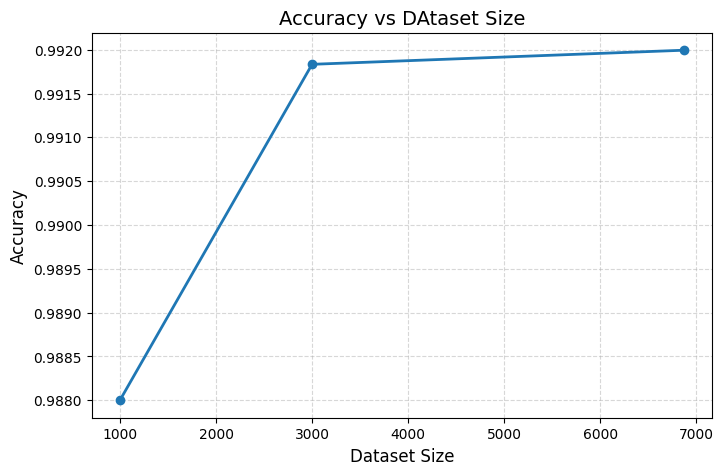

In [25]:
# 1. Accuracy plot
plt.figure(figsize=(8, 5))
plt.plot(sizes, acc, marker='o', linewidth=2,)
plt.title("Accuracy vs DAtaset Size", fontsize=14)
plt.xlabel("Dataset Size", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid(True, linestyle = '--', alpha=0.5)
plt.savefig("../../Main_plots/binary_asteroids_vs_comets/accuracy_vs_size.png")
plt.show()
plt.close()


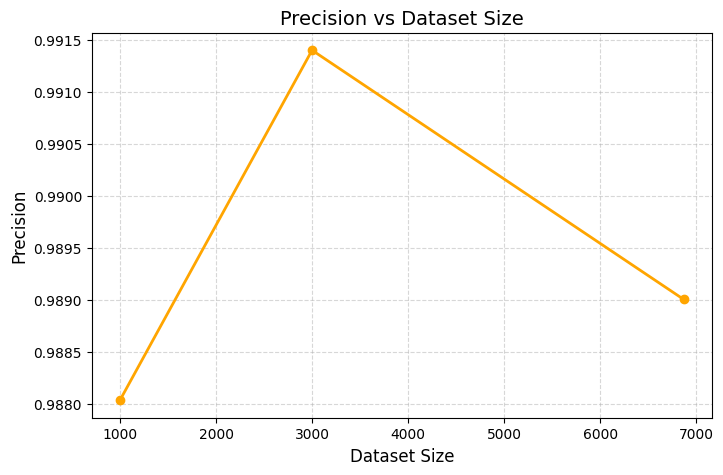

In [26]:
# 2. Precision plot
plt.figure(figsize=(8, 5))
plt.plot(sizes, precs, marker='o', color='orange', linewidth=2)
plt.title("Precision vs Dataset Size", fontsize=14)
plt.xlabel("Dataset Size", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.grid(True, linestyle = '--', alpha=0.5)
plt.savefig("../../Main_plots/binary_asteroids_vs_comets/precision_vs_size.png", dpi=300)
plt.show()
plt.close()



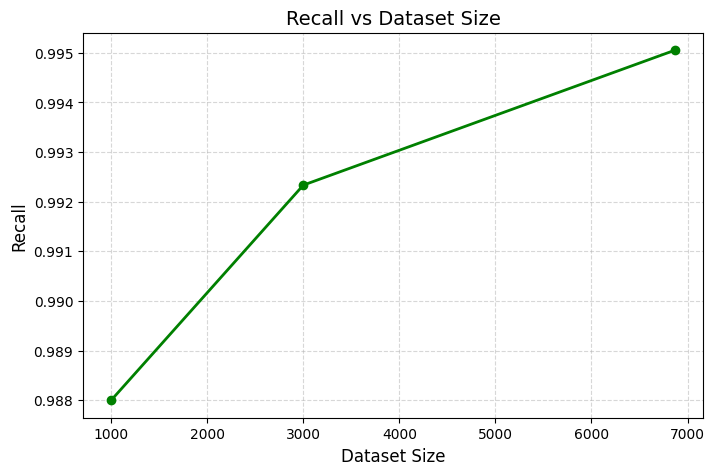

In [27]:
# 3. Recall plot
plt.figure(figsize=(8, 5))
plt.plot(sizes, recs, marker='o', color='green', linewidth=2)
plt.title("Recall vs Dataset Size", fontsize=14)
plt.xlabel("Dataset Size", fontsize=12)
plt.ylabel("Recall", fontsize=12)
plt.grid(True, linestyle = '--', alpha=0.5)
plt.savefig("../../Main_plots/binary_asteroids_vs_comets/recall_vs_size.png", dpi=300)
plt.show()
plt.close()
# 4. F1 Score plot

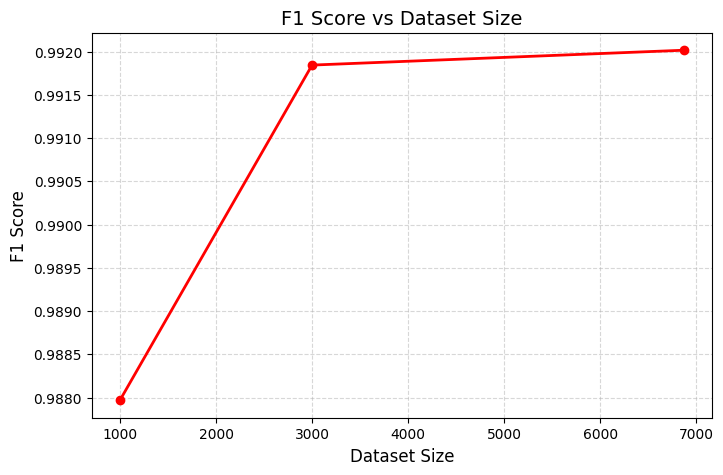

In [28]:
# 4. F1 Score plot
plt.figure(figsize=(8, 5))
plt.plot(sizes, f1s, marker='o', color='red', linewidth=2)
plt.title("F1 Score vs Dataset Size", fontsize=14)
plt.xlabel("Dataset Size", fontsize=12)
plt.ylabel("F1 Score", fontsize=12)
plt.grid(True, linestyle = '--', alpha=0.5)
plt.savefig("../../Main_plots/binary_asteroids_vs_comets/f1score_vs_size.png", dpi=300)
plt.show()
plt.close()

## Diagnostics to detect overfitting

In [20]:
def eval_size_rf(n_total, n_splits=100):
    n_per = min(n_total//2, len(com), len(ast))
    com_sub = com.sample(n=n_per, random_state=42)
    ast_sub = ast.sample(n=n_per, random_state=42)
    df_sub = pd.concat([com_sub, ast_sub], ignore_index=True)
    X_sub = df_sub[["e","q","i"]].values
    y_sub = df_sub["label"].values

    splitter = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=42)
    train_accs, test_accs, precs, recs, f1s = [], [], [], [], []

    for train_idx, test_idx in splitter.split(X_sub, y_sub):
        clf = RandomForestClassifier(n_estimators=300, class_weight="balanced_subsample")
        clf.fit(X_sub[train_idx], y_sub[train_idx])

        train_pred = clf.predict(X_sub[train_idx])
        test_pred = clf.predict(X_sub[test_idx])

        train_accs.append(accuracy_score(y_sub[train_idx], train_pred))
        test_accs.append(accuracy_score(y_sub[test_idx], test_pred))
        p, r, f1, _ = precision_recall_fscore_support(
            y_sub[test_idx], test_pred, average="binary", zero_division=0
        )
        precs.append(p); recs.append(r); f1s.append(f1)

    return {
        "size": 2*n_per,
        "train_acc_mean": float(np.mean(train_accs)),
        "test_acc_mean": float(np.mean(test_accs)),
        "acc_gap": float(np.mean(train_accs) - np.mean(test_accs)),
        "prec_mean": float(np.mean(precs)),
        "rec_mean": float(np.mean(recs)),
        "f1_mean": float(np.mean(f1s)),
    }

for n in sizes:
    print(eval_size_rf(n))


{'size': 1000, 'train_acc_mean': 1.0, 'test_acc_mean': 0.9871000000000001, 'acc_gap': 0.012899999999999912, 'prec_mean': 0.9839288320631806, 'rec_mean': 0.9904999999999999, 'f1_mean': 0.987147848746261}
{'size': 3000, 'train_acc_mean': 1.0, 'test_acc_mean': 0.990633333333333, 'acc_gap': 0.009366666666666967, 'prec_mean': 0.9897206806401116, 'rec_mean': 0.9916000000000001, 'f1_mean': 0.990644593028138}
{'size': 6868, 'train_acc_mean': 1.0, 'test_acc_mean': 0.9919650655021833, 'acc_gap': 0.00803493449781667, 'prec_mean': 0.9888179112398261, 'rec_mean': 0.9951965065502183, 'f1_mean': 0.9919919908838779}
